<a href="https://colab.research.google.com/github/MengOonLee/Deep_learning/blob/master/TensorFlow2/Customise/SubclassCustom/Subclassing_custom_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model subclassing and custom training loops

 ## Coding tutorials
 #### [1. Model subclassing](#coding_tutorial_1)
 #### [2. Custom layers](#coding_tutorial_2)
 #### [3. Automatic differentiation](#coding_tutorial_3)
 #### [4. Custom training loops](#coding_tutorial_4)
 #### [5. tf.function decorator](#coding_tutorial_5)

***
<a id="coding_tutorial_1"></a>
## Model subclassing

#### Create a simple model using the model subclassing API

In [ ]:
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
tf.get_logger().setLevel("ERROR")

# Build the model
class MyModel(tf.keras.Model):
    def __init__(self, num_classes, **kwargs):
        super().__init__(**kwargs)
        self.dense_1 = tf.keras.layers.Dense(units=64,
            activation=tf.keras.activations.relu)
        self.dense_2 = tf.keras.layers.Dense(units=10,
            activation=tf.keras.activations.relu)
        self.dense_3 = tf.keras.layers.Dense(units=num_classes,
            activation=tf.keras.activations.softmax)
        self.dropout = tf.keras.layers.Dropout(rate=0.4)

    def call(self, inputs, training=True):
        x1 = self.dense_1(inputs)
        x2 = self.dense_2(inputs)
        concat = tf.keras.layers.Concatenate()([x1, x2])
        concat = self.dropout(concat, training=training)
        return self.dense_3(concat)

# Print the model summary
my_model = MyModel(num_classes=5, name="my_model")
my_model(inputs=tf.random.normal(shape=(1, 10)))
my_model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  704       
                                                                 
 dense_1 (Dense)             multiple                  110       
                                                                 
 dense_2 (Dense)             multiple                  375       
                                                                 
 dropout (Dropout)           multiple                  0         
                                                                 
Total params: 1189 (4.64 KB)
Trainable params: 1189 (4.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


***
<a id="coding_tutorial_2"></a>
## Custom layers

#### Create custom layers

In [ ]:
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
tf.get_logger().setLevel("ERROR")

# Create a custom layer to accumulate means of output values
class MyLayerMean(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        # Specify trainable weights
        self.b = self.add_weight(shape=(units,),
            initializer=tf.keras.initializers.Zeros())
        self.sum_activation = tf.Variable(
            initial_value=tf.zeros(shape=(units,)),
            trainable=False)
        self.number_call = tf.Variable(initial_value=0,
            trainable=False)

    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
            initializer=tf.keras.initializers.RandomNormal())

    def call(self, inputs):
        activations = tf.linalg.matmul(a=inputs, b=self.w) + self.b
        self.sum_activation.assign_add(delta=tf.math.reduce_sum(
            input_tensor=activations, axis=0))
        self.number_call.assign_add(delta=inputs.shape[0])
        return activations, self.sum_activation / tf.cast(
                x=self.number_call, dtype=tf.float32)

dense_layer = MyLayerMean(units=3)

# Test the layer
x = tf.ones(shape=(2, 5))
y, activation_means = dense_layer(inputs=x)
print("trainable weights:", len(dense_layer.trainable_weights))
print("non-trainable weights:", len(dense_layer.non_trainable_weights))
print(f"activation_means: {activation_means.numpy()}")
print(f"weights: {dense_layer.weights}")

trainable weights: 2
non-trainable weights: 2
activation_means: [ 0.01885552 -0.07703885 -0.2915517 ]
weights: [<tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>, <tf.Variable 'my_layer_mean/Variable:0' shape=(5, 3) dtype=float32, numpy=
array([[-0.02358919, -0.01442928, -0.0221293 ],
       [ 0.06809177, -0.09231842, -0.06502789],
       [ 0.01064425,  0.0060349 , -0.04163619],
       [-0.0387267 ,  0.03659106, -0.10442163],
       [ 0.00243539, -0.01291711, -0.05833671]], dtype=float32)>, <tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([ 0.03771103, -0.1540777 , -0.5831034 ], dtype=float32)>, <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=2>]


#### Implement the custom layers into a model

In [ ]:
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
tf.get_logger().setLevel("ERROR")

# Build the model using custom layers with the model subclassing API
class MyModel(tf.keras.Model):
    def __init__(self, units_1, units_2, units_3, **kwargs):
        super().__init__(**kwargs)
        # Define layers
        self.layer_1 = MyLayer(units=units_1)
        self.layer_2 = MyLayer(units=units_2)
        self.layer_3 = MyLayer(units=units_3)
        self.dropout = MyDropout(rate=0.5)

    def call(self, inputs):
        # Define forward pass
        x = self.layer_1(inputs=inputs)
        x = tf.nn.relu(features=x)
        x = self.dropout(inputs=x)
        x = self.layer_2(inputs=x)
        x = tf.nn.relu(features=x)
        x = self.dropout(inputs=x)
        x = self.layer_3(inputs=x)
        return tf.nn.softmax(logits=x)

# Create a custom layer
class MyLayer(tf.keras.layers.Layer):
  def __init__(self, units, **kwargs):
      super().__init__(**kwargs)
      self.units = units
      self.b = self.add_weight(shape=(units,),
          initializer=tf.keras.initializers.Zeros())

  def build(self, input_shape):
      self.w = self.add_weight(shape=(input_shape[-1], self.units),
          initializer=tf.keras.initializers.RandomNormal())

  def call(self, inputs):
      return tf.linalg.matmul(a=inputs, b=self.w) + self.b

# Create a Dropout layer as a custom layer
class MyDropout(tf.keras.layers.Layer):
    def __init__(self, rate, **kwargs):
        super().__init__(**kwargs)
        self.rate = rate

    def call(self, inputs):
        # Define forward pass for dropout layer
        return tf.nn.dropout(x=inputs, rate=self.rate)

# Instantiate a model object
my_model = MyModel(units_1=64, units_2=64, units_3=46, name="my_model")
print(my_model(inputs=tf.random.normal(shape=(1, 10000))))
my_model.summary()

tf.Tensor(
[[0.03964709 0.01326959 0.02763752 0.01076229 0.00946367 0.03262108
  0.01824417 0.00908988 0.06717899 0.0657099  0.01522712 0.01349179
  0.02473041 0.0173228  0.01864109 0.03071251 0.01356732 0.01164669
  0.03300928 0.00993308 0.01679035 0.01374916 0.06827163 0.02038475
  0.00887606 0.01661217 0.01125773 0.0161174  0.02482517 0.01127255
  0.00647558 0.01062837 0.01034763 0.00456736 0.05896313 0.00457546
  0.00695589 0.01401419 0.02193612 0.03387663 0.02122179 0.0189374
  0.02321724 0.03404636 0.02700518 0.01316846]], shape=(1, 46), dtype=float32)
Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_layer (MyLayer)          multiple                  640064    
                                                                 
 my_dropout (MyDropout)      multiple                  0         
                                                                 
 my_layer_1 (MyLayer)

***
<a id="coding_tutorial_3"></a>
## Automatic differentiation

In [ ]:
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
tf.get_logger().setLevel("ERROR")

x = tf.constant(value=[0, 1, 2, 3], dtype=tf.float32)

with tf.GradientTape() as tape:
    tape.watch(tensor=x)
    y = tf.math.reduce_sum(input_tensor=x**2)
    z = tf.math.sin(x=y)
    dz_dy, dz_dx = tape.gradient(target=z, sources=[y, x])

print(f"dz_dy: {dz_dy}")
print(f"dz_dx: {dz_dx}")

dz_dy: 0.13673722743988037
dz_dx: [0.         0.27347445 0.5469489  0.82042336]


#### Create synthetic data

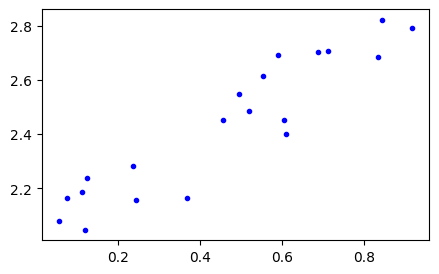

In [1]:
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
tf.get_logger().setLevel("ERROR")
%matplotlib inline
import matplotlib.pyplot as plt

# Create data from a noise contaminated linear model
@tf.function
def MakeNoisyData(w, b, n=20):
    x = tf.random.uniform(shape=(n,))
    noise = tf.random.normal(shape=(len(x),), stddev=0.1)
    y = w * x + b + noise
    return x, y

w, b = 1, 2
x_train, y_train = MakeNoisyData(w=w, b=b)

plt.figure(figsize=(5, 3))
plt.plot(x_train, y_train, 'b.')
plt.show()

#### Build, train and plot the linear regression model

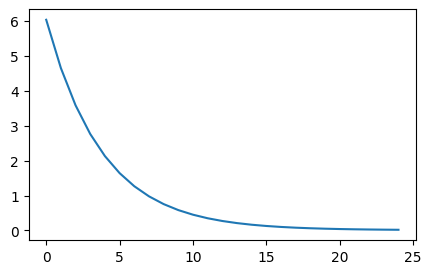

w:1,  trained w:[0.8987737]
b:2,  trained b:[1.9256457]


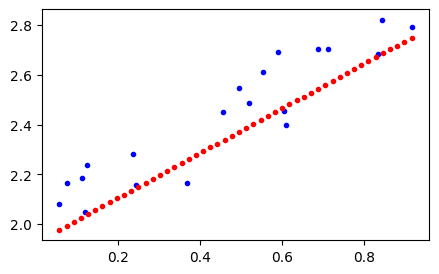

In [2]:
import numpy as np
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
tf.get_logger().setLevel("ERROR")
%matplotlib inline
import matplotlib.pyplot as plt

# Build a custom layer for the linear regression model
class LinearLayer(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super().__init__(**kwargs)
        self.w = self.add_weight(shape=(units,),
            initializer=tf.keras.initializers.RandomNormal())
        self.b = self.add_weight(shape=(units,),
            initializer=tf.keras.initializers.Zeros())

    def call(self, inputs):
        return self.w*inputs + self.b

linear_regression = LinearLayer(units=1)

# Define the mean squared error loss function & gradients
@tf.function
def get_loss_and_grad(x, y):
    with tf.GradientTape() as tape:
        y_pred = linear_regression(inputs=x_train)
        loss = tf.math.reduce_mean(
            input_tensor=tf.math.square(x=(y_pred-y)))
        grad = tape.gradient(target=loss,
            sources=linear_regression.trainable_variables)
    return loss, grad

# Implement a gradient descent training loop for the linear regression model
lr = 0.05
steps = 25

losses = []
for i in range(steps):
    loss, grad = get_loss_and_grad(x=x_train, y=y_train)
    losses.append(loss.numpy())
    linear_regression.w.assign_sub(delta=lr*grad[0])
    linear_regression.b.assign_sub(delta=lr*grad[1])

plt.figure(figsize=(5, 3))
plt.plot(losses)
plt.show()

# Plot the learned regression model
print("w:{},  trained w:{}".format(w, linear_regression.w.numpy()))
print("b:{},  trained b:{}".format(b, linear_regression.b.numpy()))

plt.figure(figsize=(5, 3))
plt.plot(x_train, y_train, 'b.')

x_linear_regression = np.linspace(start=min(x_train),
    stop=max(x_train), num=50)
y_linear_regression = linear_regression.w * x_linear_regression \
    + linear_regression.b
plt.plot(x_linear_regression, y_linear_regression, 'r.')
plt.show()

***
<a id="coding_tutorial_4"></a>
## Custom training loops

In [ ]:
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
tf.get_logger().setLevel("ERROR")
import numpy as np

my_model = MyModel()

# def loss(y_hat, y):
#     return tf.math.reduce_mean(
#         input_tensor=tf.math.square(x=(y_hat - y)))

loss = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.SGD(
    learning_rate=0.05, momentum=0.9)

@tf.function
def get_loss_and_grads(inputs, outputs):
    with tf.GradientTape() as tape:
        current_loss = loss(y_pred=my_model(inputs), y_true=outputs)
        grads = tape.gradient(target=current_loss,
            sources=my_model.trainable_variables)
    return current_loss, grads

epoch_losses = []
for epoch in range(num_epochs):
    batch_losses = []
    for inputs, outputs in training_datasets:
        current_loss, grads = get_loss_and_grads(
            inputs=inputs, outputs=outputs)
        optimizer.apply_gradients(grads_and_vars=\
            zip(grads, my_model.trainable_variables))
        batch_losses.append(current_loss)
    epoch_losses.append(np.mean(a=batch_losses))

#### Load the reuters dataset and define the class_names

In [ ]:
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
tf.get_logger().setLevel("ERROR")

# Load the dataset
(train_data, train_labels), (test_data, test_labels) = \
    tf.keras.datasets.reuters.load_data(num_words=10000)

class_names = [
    'cocoa', 'grain', 'veg-oil', 'earn', 'acq', 'wheat', 'copper', 'housing',
    'money-supply', 'coffee', 'sugar', 'trade', 'reserves', 'ship', 'cotton',
    'carcass', 'crude', 'nat-gas', 'cpi', 'money-fx', 'interest', 'gnp',
    'meal-feed', 'alum', 'oilseed', 'gold', 'tin', 'strategic-metal',
    'livestock', 'retail', 'ipi', 'iron-steel', 'rubber', 'heat', 'jobs',
    'lei', 'bop', 'zinc', 'orange', 'pet-chem', 'dlr', 'gas', 'silver',
    'wpi', 'hog', 'lead'
]

# Print the class of the first sample
print("Label: {}".format(class_names[train_labels[0]]))

print("Shape of y_train:", train_labels.shape)
print("Shape of y_test:", test_labels.shape)

Label: earn
Shape of y_train: (8982,)
Shape of y_test: (2246,)


#### Get the dataset word index

In [ ]:
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
tf.get_logger().setLevel("ERROR")

# Load the Reuters word index
word_to_index = tf.keras.datasets.reuters.get_word_index()
invert_word_index = dict([(value, key)
    for (key, value) in word_to_index.items()])

# Print the first data example sentence
text_news = ' '.join([invert_word_index.get(i - 3, '?')
    for i in train_data[0]])
print(text_news)

? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


#### Preprocess the data

In [ ]:
import numpy as np

# Define a function that encodes the data into a 'bag of words' representation
def bag_of_words(text_samples, elements=10000):
    output = np.zeros(shape=(len(text_samples), elements))
    for i, word in enumerate(text_samples):
        output[i, word] = 1.
    return output

x_train = bag_of_words(text_samples=train_data)
x_test = bag_of_words(text_samples=test_data)

print("Shape of x_train:", x_train.shape)
print("Shape of x_test:", x_test.shape)

Shape of x_train: (8982, 10000)
Shape of x_test: (2246, 10000)


#### Build the model

In [ ]:
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
tf.get_logger().setLevel("ERROR")

# Define the custom layers and model
class MyModel(tf.keras.Model):
    def __init__(self, units_1, units_2, units_3, **kwargs):
        super().__init__(**kwargs)
        # Define layers
        self.layer_1 = MyLayer(units=units_1)
        self.layer_2 = MyLayer(units=units_2)
        self.layer_3 = MyLayer(units=units_3)
        self.dropout = MyDropout(rate=0.5)

    def call(self, inputs):
        # Define forward pass
        x = self.layer_1(inputs=inputs)
        x = tf.nn.relu(features=x)
        x = self.dropout(inputs=x)
        x = self.layer_2(inputs=x)
        x = tf.nn.relu(features=x)
        x = self.dropout(inputs=x)
        x = self.layer_3(inputs=x)
        return tf.nn.softmax(logits=x)

class MyLayer(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.b = self.add_weight(shape=(units,),
            initializer=tf.keras.initializers.Zeros(),
            name="bias")

    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
            initializer=tf.keras.initializers.RandomNormal(),
            name="kernel")

    def call(self, inputs):
        return tf.linalg.matmul(a=inputs, b=self.w) + self.b

class MyDropout(tf.keras.layers.Layer):
    def __init__(self, rate, **kwargs):
        super().__init__(**kwargs)
        self.rate = rate

    def call(self, inputs):
        # Define forwared pass for dropout layer
        return tf.nn.dropout(x=inputs, rate=self.rate)

# Instantiate the model object
model = MyModel(units_1=64, units_2=64, units_3=46)
print(model(inputs=tf.random.normal(shape=(1, 10000))))
model.summary()

tf.Tensor(
[[0.03964711 0.01326958 0.02763753 0.01076229 0.00946367 0.03262109
  0.01824417 0.00908988 0.06717901 0.06570987 0.01522713 0.01349179
  0.02473041 0.01732281 0.01864108 0.03071251 0.01356731 0.01164669
  0.03300926 0.00993308 0.01679034 0.01374915 0.06827164 0.02038475
  0.00887607 0.01661218 0.01125773 0.01611739 0.02482517 0.01127254
  0.00647558 0.01062837 0.01034763 0.00456736 0.05896316 0.00457546
  0.00695589 0.01401417 0.02193612 0.03387661 0.02122178 0.0189374
  0.02321725 0.03404637 0.02700517 0.01316846]], shape=(1, 46), dtype=float32)
Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_layer (MyLayer)          multiple                  640064    
                                                                 
 my_layer_1 (MyLayer)        multiple                  4160      
                                                                 
 my_layer_2 (MyLayer)

#### Define the loss function and optimizer



In [ ]:
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
tf.get_logger().setLevel("ERROR")

# Define the categorical cross entropy loss and Adam optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

@tf.function
def loss(model, x, y, wd):
    kernel_variables = []
    for l in model.layers:
        for w in l.weights:
            if 'kernel' in w.name:
             kernel_variables.append(w)
    wd_penalty = wd * tf.math.reduce_sum([tf.math.reduce_sum(
        tf.math.square(x=k)) for k in kernel_variables])
    y_ = model(x)
    return loss_object(y_true=y, y_pred=y_) + wd_penalty

# Define a function to compute the forward and backward pass
@tf.function
def grad(model, inputs, targets, wd):
    with tf.GradientTape() as tape:
        loss_value = loss(model=model, x=inputs,
            y=targets, wd=wd)
    return loss_value, tape.gradient(target=loss_value,
        sources=model.trainable_variables)

#### Train the model

Duration :127.644


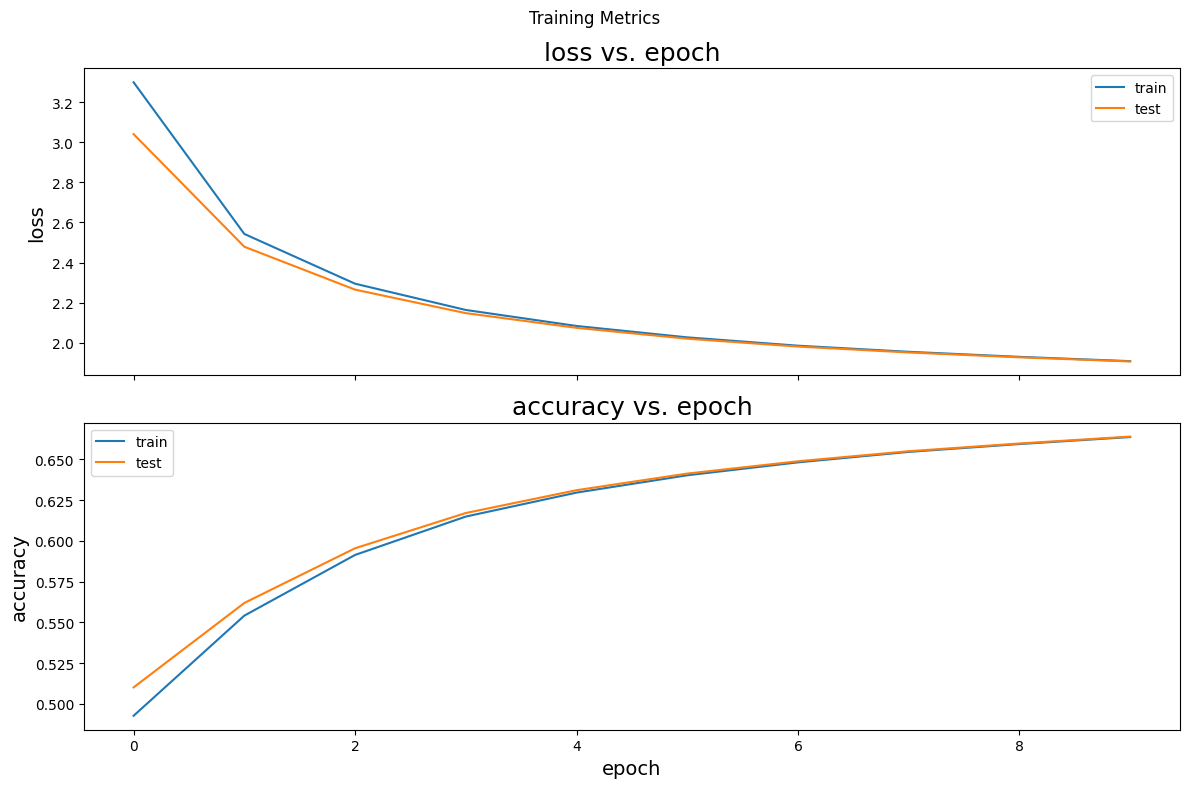

Prediction from the model
Predict: earn
  Label: earn


In [ ]:
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
tf.get_logger().setLevel("ERROR")
import numpy as np
import pandas as pd
import time
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Implement the training loop
start_time = time.time()

# Create a Dataset object for the train set
train_dataset = tf.data.Dataset.from_tensor_slices(
    tensors=(x_train, train_labels))
train_dataset = train_dataset.batch(batch_size=32)

# Create a Dataset object for the test set
test_dataset = tf.data.Dataset.from_tensor_slices(
    tensors=(x_test, test_labels))
test_dataset = test_dataset.batch(batch_size=32)

# Collect average loss and accuracy
epoch_loss_avg = tf.keras.metrics.Mean()
epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()

# Keep results for plotting
train_loss_results, test_loss_results = [], []
train_accuracy_results, test_accuracy_results = [], []
num_epochs = 10
weight_decay = 0.005

for epoch in range(num_epochs):

    # Training loop
    for x, y in train_dataset:
        # Compute current loss
        loss_value, grads = grad(model=model, inputs=x,
            targets=y, wd=weight_decay)
        # Optimize the model
        optimizer.apply_gradients(grads_and_vars=\
            zip(grads, model.trainable_variables))

        epoch_loss_avg(values=loss_value)
        # Compare predicted label to actual label
        epoch_accuracy(y_true=tf.keras.utils.to_categorical(y=y),
            y_pred=model(x))

    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())

    # Evaluate the model
    # Loop over the test set and print scores
    for x, y in test_dataset:
        # Compute current loss
        loss_value = loss(model=model, x=x,
            y=y, wd=weight_decay)

        epoch_loss_avg(values=loss_value)
        # Compare predicted label to actual label
        epoch_accuracy(y_true=tf.keras.utils.to_categorical(y=y),
            y_pred=model(x))

    test_loss_results.append(epoch_loss_avg.result())
    test_accuracy_results.append(epoch_accuracy.result())

# End epoch
print("Duration :{:.3f}".format(time.time() - start_time))

df_history = pd.DataFrame({
    "epoch": np.arange(num_epochs),
    "train_loss": np.array(train_loss_results),
    "test_loss": np.array(test_loss_results),
    "train_accuracy": np.array(train_accuracy_results),
    "test_accuracy": np.array(test_accuracy_results)
})

# Plot the learning curves
# Plot the training loss and accuracy
fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')
axes[1].set_xlabel(xlabel="epoch", fontsize=14)
for ax, metric in zip(axes, ["loss", "accuracy"]):
    sns.lineplot(ax=ax, label="train", data=df_history,
        x="epoch", y=f"train_{metric}")
    sns.lineplot(ax=ax, label="test", data=df_history,
        x="epoch", y=f"test_{metric}")
    ax.legend(loc="best")
    ax.set_ylabel(ylabel=f"{metric}", fontsize=14)
    ax.set_title(label=f"{metric} vs. epoch", fontsize=18)

fig.tight_layout()
plt.show()

# # Get the model prediction for an example input
predicted_label = np.argmax(model(x_train[np.newaxis, 0]), axis=1)[0]
print("Prediction from the model")
print("Predict: {}".format(class_names[predicted_label]))
print("  Label: {}".format(class_names[train_labels[0]]))

***
<a id="coding_tutorial_5"></a>
## tf.function decorator

In [ ]:
import tensorflow as tf
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import SGD

my_model = MyModel()
loss = MeanSquaredError()
optimizer = SGD(learning_rate=0.05, momentum=0.9)

@tf.function
def get_loss_and_grads(inputs, outputs):
    with tf.GradientTape() as tape:
        current_loss = loss(my_model(inputs), outputs)
        grads = tape.gradient(current_loss,
            my_model.trainable_variables)
    return current_loss, grads

for epoch in range(num_epochs):
    for inputs, outputs in training_dataset:
        current_loss, grads = get_loss_and_grads(inputs, outputs)
        optimizer.apply_gradients(zip(grads,
            my_model.trainable_variables))

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Softmax
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import reuters
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import time

#### Build the model

In [ ]:
# Define the custom layers and model

class MyLayer(Layer):

    def __init__(self, units):
        super(MyLayer, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
            initializer='random_normal', name='kernel')
        self.b = self.add_weight(shape=(self.units, ),
            initializer='zeros', name='bias')

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

class MyDropout(Layer):

    def __init__(self, rate):
        super(MyDropout, self).__init__()
        self.rate = rate

    def call(self, inputs):
        # Define forwared pass for dropout layer
        return tf.nn.dropout(inputs, rate=self.rate)

class MyModel(Model):

    def __init__(self, units_1, units_2, units_3):
        super(MyModel, self).__init__()
        # Define layers
        self.layer_1 = MyLayer(units_1)
        self.dropout_1 = MyDropout(0.5)
        self.layer_2 = MyLayer(units_2)
        self.dropout_2 = MyDropout(0.5)
        self.layer_3 = MyLayer(units_3)
        self.softmax = Softmax()

    def call(self, inputs):
        # Define forward pass
        x = self.layer_1(inputs)
        x = tf.nn.relu(x)
        x = self.dropout_1(x)
        x = self.layer_2(x)
        x = tf.nn.relu(x)
        x = self.dropout_2(x)
        x = self.layer_3(x)
        return self.softmax(x)

# Initialize a new model

model = MyModel(64, 64, 46)
print(model(tf.ones((1, 10000))))
model.summary()

tf.Tensor(
[[0.01971349 0.0128117  0.01281833 0.01806461 0.02666165 0.01890017
  0.03147139 0.00964301 0.01691275 0.0289935  0.01865787 0.02058025
  0.01223264 0.02273865 0.00546703 0.02286484 0.0150119  0.01376886
  0.00987451 0.02398963 0.02541195 0.04581803 0.01048673 0.03026778
  0.01948599 0.0414695  0.04172915 0.01312426 0.01371575 0.02741901
  0.01029295 0.02534913 0.04003927 0.01897906 0.01478054 0.0186229
  0.01920601 0.01592984 0.02524102 0.0527998  0.0153937  0.015901
  0.03862935 0.03238732 0.01285238 0.01349079]], shape=(1, 46), dtype=float32)
Model: "my_model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
my_layer_11 (MyLayer)        multiple                  640064    
_________________________________________________________________
my_dropout_6 (MyDropout)     multiple                  0         
_________________________________________________________________
my_layer_12 (MyLayer)

#### Load the reuters dataset and define the class_names

In [ ]:
# Load the dataset

from tensorflow.keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = \
    reuters.load_data(num_words=10000)

class_names = ['cocoa','grain','veg-oil','earn','acq','wheat',
    'copper','housing','money-supply','coffee','sugar','trade',
    'reserves','ship','cotton','carcass','crude','nat-gas','cpi',
    'money-fx','interest','gnp','meal-feed','alum','oilseed','gold',
    'tin','strategic-metal','livestock','retail','ipi','iron-steel',
    'rubber','heat','jobs','lei','bop','zinc','orange','pet-chem',
    'dlr','gas','silver','wpi','hog','lead']

In [ ]:
# Print the class of the first sample

print("Label: {}".format(class_names[train_labels[0]]))

Label: earn


#### Get the dataset word index

In [ ]:
# Load the Reuters word index

word_to_index = reuters.get_word_index()

invert_word_index = dict([(value, key) for (key, value)
    in word_to_index.items()])

In [ ]:
# Print the first data example sentence

text_news = ' '.join([invert_word_index.get(i - 3, '?')
    for i in train_data[0]])
print(text_news)

? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


#### Preprocess the data

In [ ]:
# Define a function that encodes the data into a 'bag of words' representation

def bag_of_words(text_samples, elements=10000):
    output = np.zeros((len(text_samples), elements))
    for i, word in enumerate(text_samples):
        output[i, word] = 1.
    return output

x_train = bag_of_words(train_data)
x_test = bag_of_words(test_data)

print("Shape of x_train:", x_train.shape)
print("Shape of x_test:", x_test.shape)

Shape of x_train: (8982, 10000)
Shape of x_test: (2246, 10000)


#### Define the loss function and optimizer

In [ ]:
# Define the categorical cross entropy loss and Adam optimizer

loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

def loss(model, x, y, wd):
    kernel_variables = []
    for l in model.layers:
        for w in l.weights:
            if 'kernel' in w.name:
                kernel_variables.append(w)
    wd_penalty = wd * tf.reduce_sum([tf.reduce_sum(tf.square(k))
        for k in kernel_variables])
    y_ = model(x)
    return loss_object(y_true=y, y_pred=y_) + wd_penalty

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

#### Redefine the grad function using the @tf.function decorator

In [ ]:
# Use the @tf.function decorator

@tf.function
def grad(model, inputs, targets, wd):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, wd)
    return loss_value, tape.gradient(loss_value,
        model.trainable_variables)

#### Train the model

In [ ]:
# Re-run the training loop

from tensorflow.keras.utils import to_categorical

start_time = time.time()

train_dataset = tf.data.Dataset.from_tensor_slices(
    (x_train, train_labels))
train_dataset = train_dataset.batch(32)

# Keep results for plotting
train_loss_results = []
train_accuracy_results = []

num_epochs = 10
weight_decay = 0.005

for epoch in range(num_epochs):

    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()

    # Training loop
    for x, y in train_dataset:
        # Optimize the model
        loss_value, grads = grad(model, x, y, weight_decay)
        optimizer.apply_gradients(zip(grads,
            model.trainable_variables))

        # Compute current loss
        epoch_loss_avg(loss_value)
        # Compare predicted label to actual label
        epoch_accuracy(to_categorical(y), model(x))

    # End epoch
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())

    print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(
        epoch, epoch_loss_avg.result(), epoch_accuracy.result()))

print("Duration :{:.3f}".format(time.time() - start_time))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 000: Loss: 3.318, Accuracy: 47.874%
Epoch 001: Loss: 1.906, Accuracy: 61.701%
Epoch 002: Loss: 1.816, Accuracy: 65.442%
Epoch 003: Loss: 1.771, Accuracy: 67.491%
Epoch 004: Loss: 1.754, Accuracy: 68.470%
Epoch 005: Loss: 1.737, Accuracy: 69.472%
Epoch 006: Loss: 1.730, Accuracy: 69.695%
Epoch 007: Loss: 1.705, Accuracy: 70.196%
Epoch 008: Loss: 1.705, Accuracy: 70.463%
Epoch 009: Loss: 1.706, Accuracy: 70.385%
Duration :29.538


#### Print the autograph code

In [ ]:
# Use tf.autograph.to_code to see the generated code

print(tf.autograph.to_code(grad.python_function))

def tf__grad(model, inputs, targets, wd):
    with ag__.FunctionScope('grad', 'fscope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as fscope:
        do_return = False
        retval_ = ag__.UndefinedReturnValue()
        with ag__.ld(tf).GradientTape() as tape:
            loss_value = ag__.converted_call(ag__.ld(loss), (ag__.ld(model), ag__.ld(inputs), ag__.ld(targets), ag__.ld(wd)), None, fscope)
        try:
            do_return = True
            retval_ = (ag__.ld(loss_value), ag__.converted_call(ag__.ld(tape).gradient, (ag__.ld(loss_value), ag__.ld(model).trainable_variables), None, fscope))
        except:
            do_return = False
            raise
        return fscope.ret(retval_, do_return)

